In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


def trace_binary_path(tree, sample_leaf_index):
    children_left = tree.children_left
    children_right = tree.children_right
    node = 0
    binary_path = ''
    search = sample_leaf_index
    while True:
        i = np.where(children_left == search)[0]
        if i.size:
            binary_path = '0' + binary_path
        else:
            i = np.where(children_right == search)[0]
            binary_path = '1' + binary_path
        i = i[0]
        if i == 0:
            break
        search = i
    return binary_path

def dist(x: str, y: str):
    depth = max(len(x), len(y))
    for i in range(depth):
        if x[i] != y[i]:
            return depth - i
    return 0

def children(tree):
    children_left = tree.children_left
    children_right = tree.children_right
    print(f'left: {list(enumerate(children_left))}')
    print(f'right: {list(enumerate(children_right))}')

def print_tree(tree, index = 0, offset = 0):
    if index == -1:
        return
    print_tree(tree, tree.children_left[index], offset + 1)
    print(' ' * (2 * offset) + f'{offset}:' + str(index))
    print_tree(tree, tree.children_right[index], offset + 1)


def how_many_neighbors_for_KNN(points):
    # return len(points)
    return 5

In [2]:
t = np.linspace(0, 6 * np.pi, 500)
x = t * np.cos(t)
y = t * np.sin(t)
points = np.vstack((x, y)).T

labels = np.where(t < 2 * np.pi, 'A', 'B')

N_ESTIMATORS = 10


random_trees = RandomTreesEmbedding(n_estimators=N_ESTIMATORS, random_state=42)
encoded_points = random_trees.fit_transform(points).toarray()

binary_paths = []
for estimator in random_trees.estimators_:
    leaf_indices = estimator.apply(points).ravel()
    for leaf_index in leaf_indices:
        binary_path = trace_binary_path(estimator.tree_, leaf_index)
        binary_paths.append(binary_path)

binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T
print(f'paths shape: {binary_paths.shape}')

print_tree(random_trees.estimators_[5].tree_)

num_points = len(points)
pairwise_distances = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(i + 1, num_points):
        avg_distance = 0
        for k in range(len(random_trees.estimators_)):
            # print(i, j, k)
            try:
                avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
            except IndexError as ie:
                print(ie, binary_paths[i][k], binary_paths[j][k])
                children(random_trees.estimators_[k].tree_)
                print(
                    random_trees.estimators_[k].apply([points[i], points[j]]),
                )
                raise IndexError(ie)
        avg_distance /= len(random_trees.estimators_)
        pairwise_distances[i, j] = avg_distance
        pairwise_distances[j, i] = avg_distance

# predicted_labels = []
# for i in range(num_points):
#     distances_to_A = [pairwise_distances[i, j] for j in range(num_points) if labels[j] == 'A']
#     distances_to_B = [pairwise_distances[i, j] for j in range(num_points) if labels[j] == 'B']
#     if np.mean(distances_to_A) < np.mean(distances_to_B):
#         predicted_labels.append('A')
#     else:
#         predicted_labels.append('B')

# accuracy = np.mean(np.array(predicted_labels) == labels)
# print(f"Classification Accuracy: {accuracy:.2f}")

# from sklearn.metrics import precision_score, recall_score, f1_score

# true_labels = np.array([1 if label == 'A' else 0 for label in labels])
# predicted_labels_binary = np.array([1 if label == 'A' else 0 for label in predicted_labels])
# precision = precision_score(true_labels, predicted_labels_binary, pos_label=1)
# recall = recall_score(true_labels, predicted_labels_binary, pos_label=1)
# f1 = f1_score(true_labels, predicted_labels_binary, pos_label=1)
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1-Score: {f1:.2f}")

# plt.figure(figsize=(8, 8))
# plt.scatter(x, y, c=[1 if label == 'A' else 0 for label in predicted_labels], cmap='coolwarm', alpha=0.7)
# plt.title("Spiral with Points Classified as A (Red) and B (Blue)")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.colorbar(label="Classification (A/B)")
# plt.show()

paths shape: (500, 10)
          5:5
        4:4
          5:6
      3:3
          5:8
        4:7
          5:9
    2:2
        4:11
      3:10
          5:13
        4:12
          5:14
  1:1
          5:18
        4:17
          5:19
      3:16
          5:21
        4:20
          5:22
    2:15
          5:25
        4:24
          5:26
      3:23
          5:28
        4:27
          5:29
0:0
          5:34
        4:33
          5:35
      3:32
          5:37
        4:36
          5:38
    2:31
          5:41
        4:40
          5:42
      3:39
          5:44
        4:43
          5:45
  1:30
          5:49
        4:48
          5:50
      3:47
          5:52
        4:51
          5:53
    2:46
          5:56
        4:55
          5:57
      3:54
          5:59
        4:58
          5:60


## Проверка формулы расстояния

In [3]:
a_point = np.random.randint(0, len(points))
b_point = np.random.randint(0, len(points))
k = np.random.randint(0, N_ESTIMATORS)
a_point, b_point, k = 340, 209, 6
print(f'first point: {a_point}, second point: {b_point}, tree: {k}')
print('Tree structure:')
print_tree(random_trees.estimators_[k].tree_)
print('Leaves:')
print(random_trees.estimators_[k].apply([points[a_point], points[b_point]]))
print(f'Binary paths:\n first: {binary_paths[a_point][k]}, second: {binary_paths[b_point][k]}')

first point: 340, second point: 209, tree: 6
Tree structure:
          5:5
        4:4
          5:6
      3:3
          5:8
        4:7
          5:9
    2:2
          5:12
        4:11
          5:13
      3:10
          5:15
        4:14
          5:16
  1:1
          5:20
        4:19
          5:21
      3:18
          5:23
        4:22
          5:24
    2:17
          5:27
        4:26
          5:28
      3:25
          5:30
        4:29
          5:31
0:0
          5:36
        4:35
          5:37
      3:34
          5:39
        4:38
          5:40
    2:33
      3:41
  1:32
          5:45
        4:44
          5:46
      3:43
          5:48
        4:47
          5:49
    2:42
          5:52
        4:51
          5:53
      3:50
          5:55
        4:54
          5:56
Leaves:
[53 30]
Binary paths:
 first: 11101, second: 01110


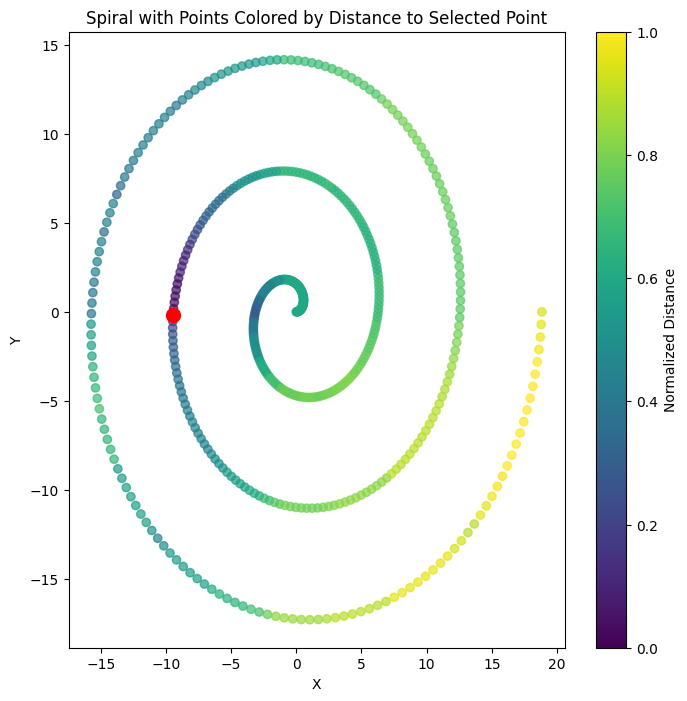

In [4]:
def color_points_by_pairwise_distance(pairwise_distances, selected_point_index):
    distances = pairwise_distances[selected_point_index]
    colors = distances / np.max(distances)
    return colors


selected_point_index = 250

colors = color_points_by_pairwise_distance(pairwise_distances, selected_point_index)

plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=colors, cmap='viridis', alpha=0.7)
plt.scatter([x[selected_point_index]], [y[selected_point_index]], c='red', s=100)
plt.title("Spiral with Points Colored by Distance to Selected Point")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Normalized Distance")
plt.show()

KNN Score:  0.9975
Classification Accuracy: 1.00
Extra Trees Accuracy: 1.0000


c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [14:59:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 1.0000
KNN Accuracy: 0.9850
SVM Accuracy: 0.9925
Extra Trees Accuracy: 1.0000


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


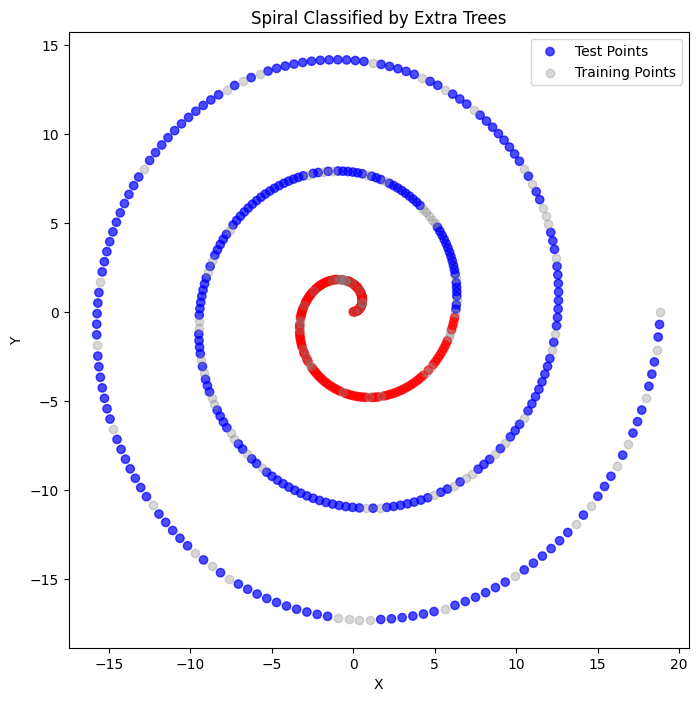

c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [14:59:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


XGBoost Accuracy: 1.0000


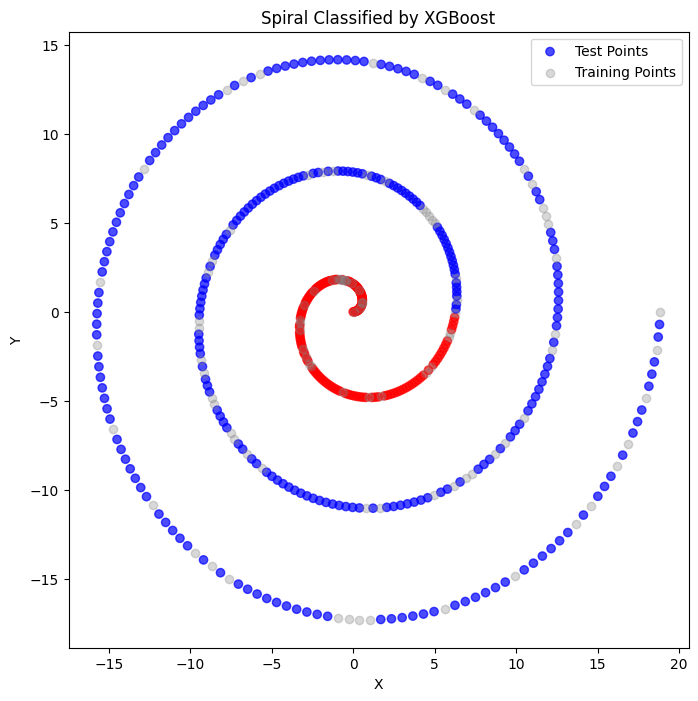

KNN Accuracy: 0.9850


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


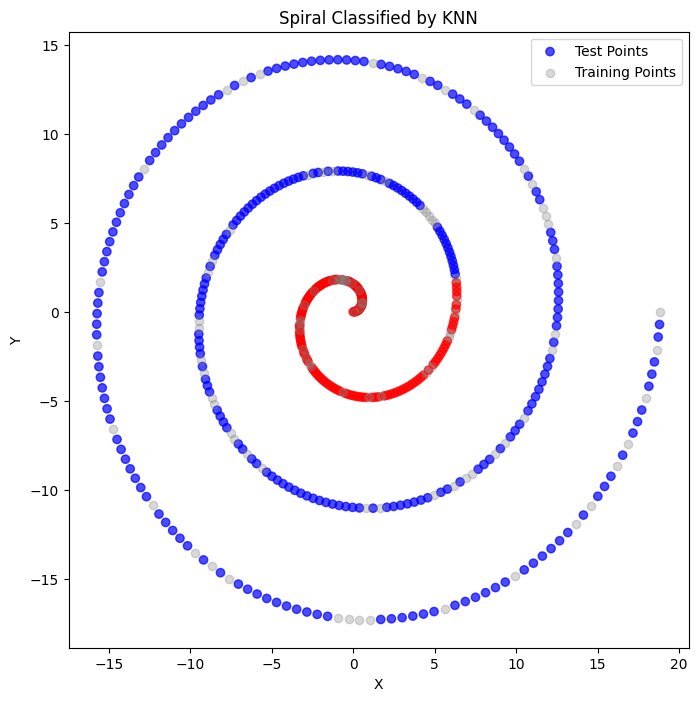

SVM Accuracy: 0.9925


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


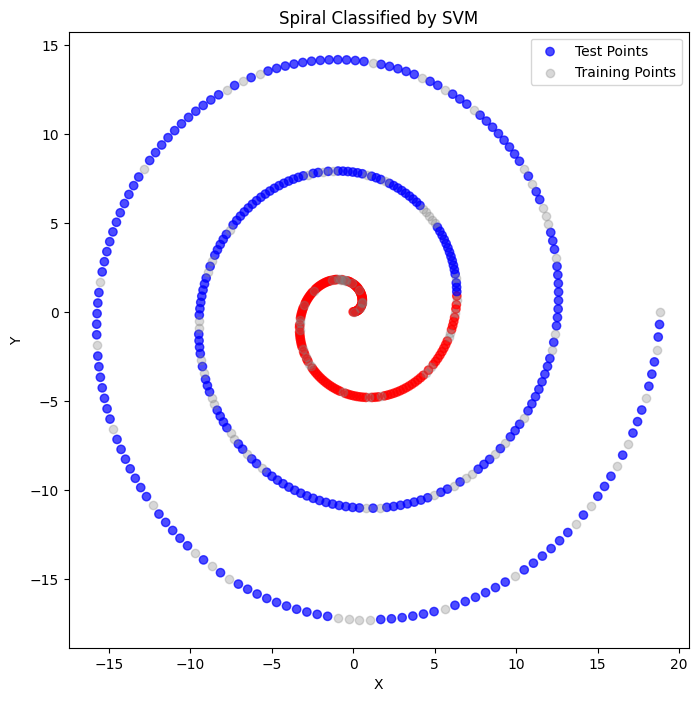

C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:102: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x[test_idx], y[test_idx], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


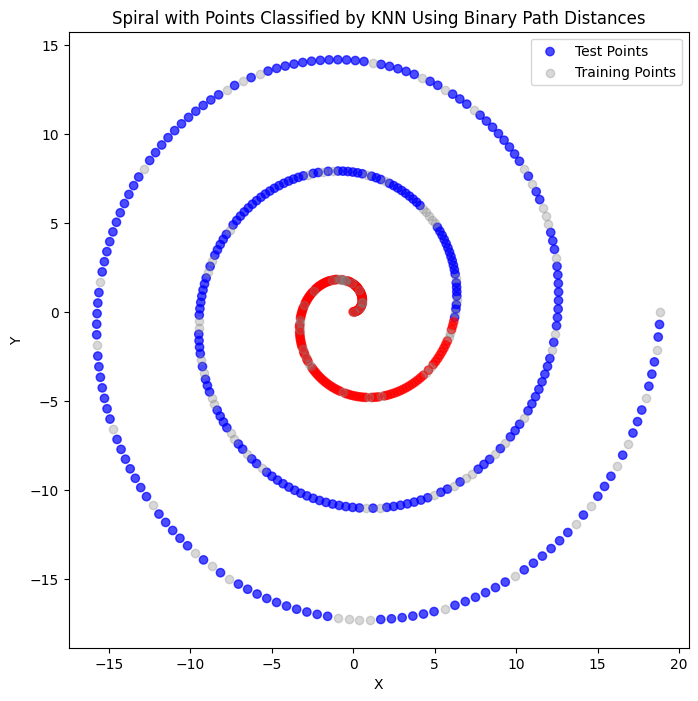

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


test_size = 0.8
num_neighbors = 5

train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)
D = pairwise_distances[:, train_idx]
train_distances = D[train_idx] 
test_distances = D[test_idx] 
train_labels = labels[train_idx]
test_labels = labels[test_idx]

knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
knn.fit(train_distances, train_labels)

print('KNN Score: ', knn.score(test_distances, test_labels))

predicted_labels = knn.predict(test_distances)

accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Classification Accuracy: {accuracy:.2f}")

def plot_decision_boundary(clf, X, y, title):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Function to visualize results
def visualize_results(X_train, X_test, y_train, y_test, predicted_labels, title):
    plt.figure(figsize=(8, 8))
    
    # Extract x and y coordinates from the test set
    x_test = X_test[:, 0]
    y_test = X_test[:, 1]
    
    # Colors for predicted labels
    colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
    
    # Plot test points with predicted labels
    plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
    
    # Plot training points in gray
    x_train = X_train[:, 0]
    y_train = X_train[:, 1]
    plt.scatter(x_train, y_train, c='gray', alpha=0.3, label="Training Points")
    
    # Add title, labels, and legend
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

def other_options(points, labels, visualize = True):
    X = points
    label_encoder = LabelEncoder()
    trans_labels = label_encoder.fit_transform(labels)
    X_train, X_test, y_train, y_test = train_test_split(X, trans_labels, test_size=test_size, random_state=42)

    classifiers = {
        "Extra Trees": ExtraTreesClassifier(n_estimators=N_ESTIMATORS, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=num_neighbors),
        "SVM": SVC(kernel='rbf', random_state=42)
    }

    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy: {accuracy:.4f}")
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        predicted_labels = label_encoder.inverse_transform(y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy: {accuracy:.4f}")
        visualize_results(X_train, X_test, y_train, y_test, predicted_labels, title=f"Spiral Classified by {name}")

other_options(points, labels)


# y = label_encoder.inverse_transform(y)
plt.figure(figsize=(8, 8))
colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
plt.scatter(x[test_idx], y[test_idx], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
plt.scatter(x[train_idx], y[train_idx], c='gray', alpha=0.3, label="Training Points")
plt.title("Spiral with Points Classified by KNN Using Binary Path Distances")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

total train points: 100
paths shape: (500, 10)
      3:3
    2:2
      3:4
  1:1
          5:8
        4:7
          5:9
      3:6
          5:11
        4:10
          5:12
    2:5
          5:15
        4:14
          5:16
      3:13
          5:18
        4:17
          5:19
0:0
          5:24
        4:23
          5:25
      3:22
          5:27
        4:26
          5:28
    2:21
          5:31
        4:30
          5:32
      3:29
          5:34
        4:33
          5:35
  1:20
          5:39
        4:38
          5:40
      3:37
          5:42
        4:41
          5:43
    2:36
          5:46
        4:45
          5:47
      3:44
        4:48
KNN Score:  0.985
Classification Accuracy: 0.98


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\823803030.py:97: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x[test_idx], y[test_idx], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


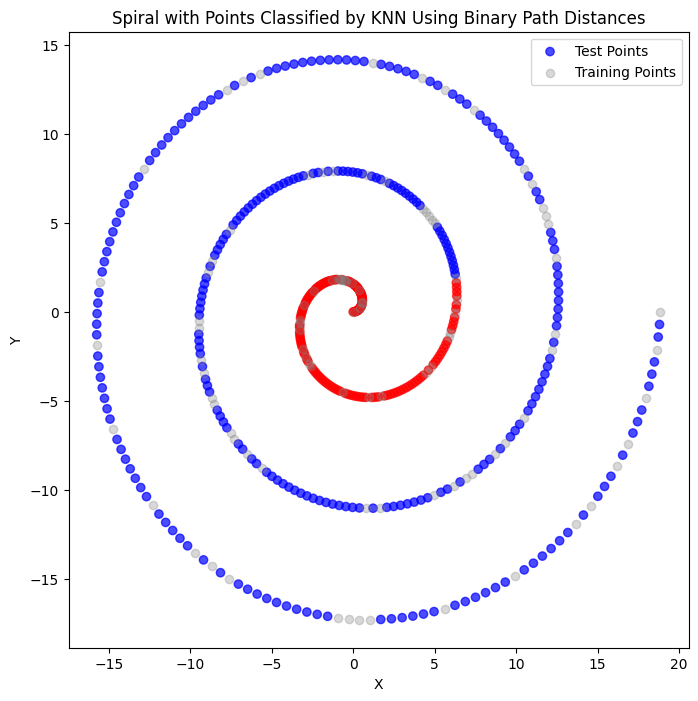

In [6]:
train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)

def rte_distances_for_train(points, train_idx, n_estimators=10):
    train_points = points[train_idx]
    random_trees = RandomTreesEmbedding(n_estimators=n_estimators, random_state=42)
    encoded_points = random_trees.fit_transform(train_points).toarray()

    binary_paths = []
    for estimator in random_trees.estimators_:
        leaf_indices = estimator.apply(points).ravel()
        for leaf_index in leaf_indices:
            binary_path = trace_binary_path(estimator.tree_, leaf_index)
            binary_paths.append(binary_path)

    binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T
    print(f'paths shape: {binary_paths.shape}')

    print_tree(random_trees.estimators_[5].tree_)

    num_points = len(points)
    pairwise_distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i + 1, num_points):
            avg_distance = 0
            for k in range(len(random_trees.estimators_)):
                # print(i, j, k)
                try:
                    avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
                except IndexError as ie:
                    print(ie, binary_paths[i][k], binary_paths[j][k])
                    children(random_trees.estimators_[k].tree_)
                    print(
                        random_trees.estimators_[k].apply([points[i], points[j]]),
                    )
                    raise IndexError(ie)
            avg_distance /= len(random_trees.estimators_)
            pairwise_distances[i, j] = avg_distance
            pairwise_distances[j, i] = avg_distance
    return pairwise_distances

train_points = points[train_idx]

print(f'total train points: {len(train_points)}')
random_trees = RandomTreesEmbedding(n_estimators=N_ESTIMATORS, random_state=42)
encoded_points = random_trees.fit_transform(train_points).toarray()

binary_paths = []
for estimator in random_trees.estimators_:
    leaf_indices = estimator.apply(points).ravel()
    for leaf_index in leaf_indices:
        binary_path = trace_binary_path(estimator.tree_, leaf_index)
        binary_paths.append(binary_path)

binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T
print(f'paths shape: {binary_paths.shape}')

print_tree(random_trees.estimators_[5].tree_)

num_points = len(points)
pairwise_small = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(i + 1, num_points):
        avg_distance = 0
        for k in range(len(random_trees.estimators_)):
            # print(i, j, k)
            try:
                avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
            except IndexError as ie:
                print(ie, binary_paths[i][k], binary_paths[j][k])
                children(random_trees.estimators_[k].tree_)
                print(
                    random_trees.estimators_[k].apply([points[i], points[j]]),
                )
                raise IndexError(ie)
        avg_distance /= len(random_trees.estimators_)
        pairwise_small[i, j] = avg_distance
        pairwise_small[j, i] = avg_distance

D = pairwise_small[:, train_idx]
train_distances = D[train_idx] 
test_distances = D[test_idx] 
train_labels = labels[train_idx]
test_labels = labels[test_idx]

knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
knn.fit(train_distances, train_labels)

print('KNN Score: ', knn.score(test_distances, test_labels))

predicted_labels = knn.predict(test_distances)

accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Classification Accuracy: {accuracy:.2f}")

plt.figure(figsize=(8, 8))
colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
plt.scatter(x[test_idx], y[test_idx], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
plt.scatter(x[train_idx], y[train_idx], c='gray', alpha=0.3, label="Training Points")
plt.title("Spiral with Points Classified by KNN Using Binary Path Distances")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

In [7]:
import numpy as np
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Generate two spirals: one for label A and one for label B (rotated by pi)
def generate_spirals(num_points=500):
    t = np.linspace(0, 6 * np.pi, num_points)
    x_a = t * np.cos(t)
    y_a = t * np.sin(t)
    x_b = t * np.cos(t + np.pi)  # Rotate by pi
    y_b = t * np.sin(t + np.pi)
    points_a = np.vstack((x_a, y_a)).T
    points_b = np.vstack((x_b, y_b)).T
    labels_a = ['A'] * len(points_a)
    labels_b = ['B'] * len(points_b)
    return np.vstack((points_a, points_b)), np.hstack((labels_a, labels_b))



# Generate the data
points, labels = generate_spirals()

# Use Random Trees Embedding to encode the points
N_ESTIMATORS = 10
random_trees = RandomTreesEmbedding(n_estimators=N_ESTIMATORS, random_state=42)
encoded_points = random_trees.fit_transform(points).toarray()

# Compute binary paths for all points
binary_paths = []
for estimator in random_trees.estimators_:
    leaf_indices = estimator.apply(points).ravel()
    for leaf_index in leaf_indices:
        binary_path = trace_binary_path(estimator.tree_, leaf_index)
        binary_paths.append(binary_path)
binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T

# Compute pairwise distances based on binary paths
num_points = len(points)
pairwise_distances = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(i + 1, num_points):
        avg_distance = 0
        for k in range(len(random_trees.estimators_)):
            avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
        avg_distance /= len(random_trees.estimators_)
        pairwise_distances[i, j] = avg_distance
        pairwise_distances[j, i] = avg_distance


KNN Score:  0.63875
Classification Accuracy: 0.64
Extra Trees Accuracy: 0.8612


c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:00:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.7350
KNN Accuracy: 0.7375
SVM Accuracy: 0.4963
Extra Trees Accuracy: 0.8612


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


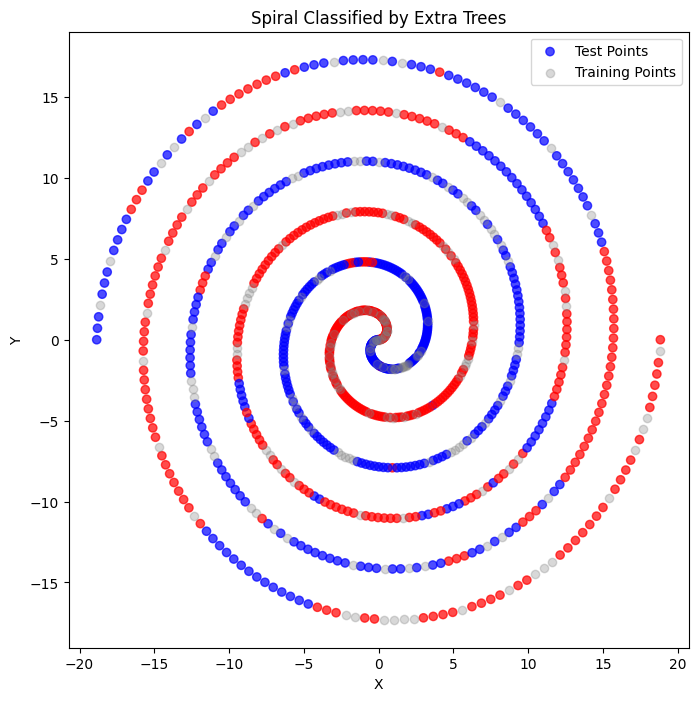

c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:00:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


XGBoost Accuracy: 0.7350


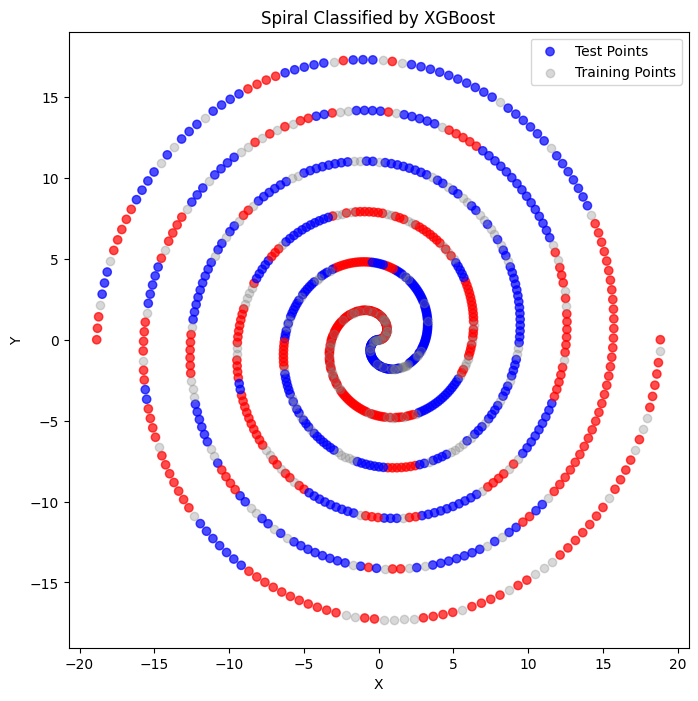

KNN Accuracy: 0.7375


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


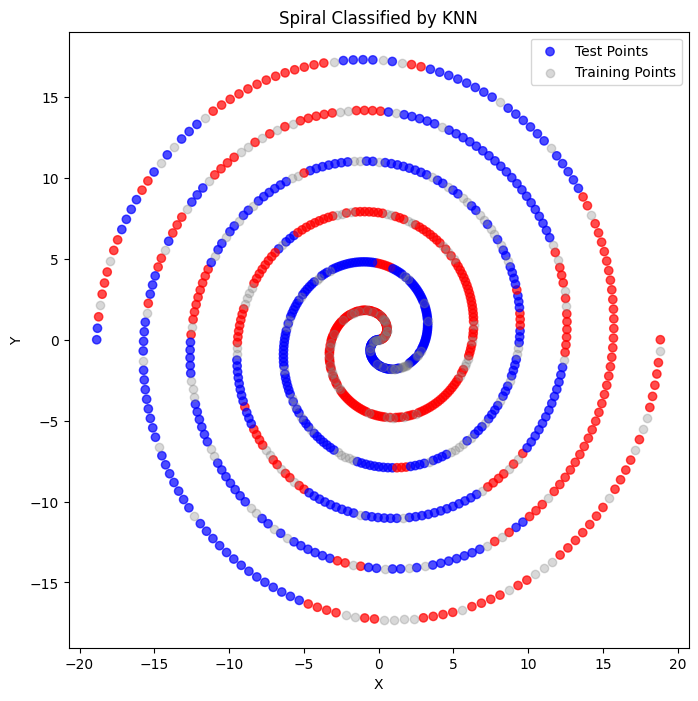

SVM Accuracy: 0.4963


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


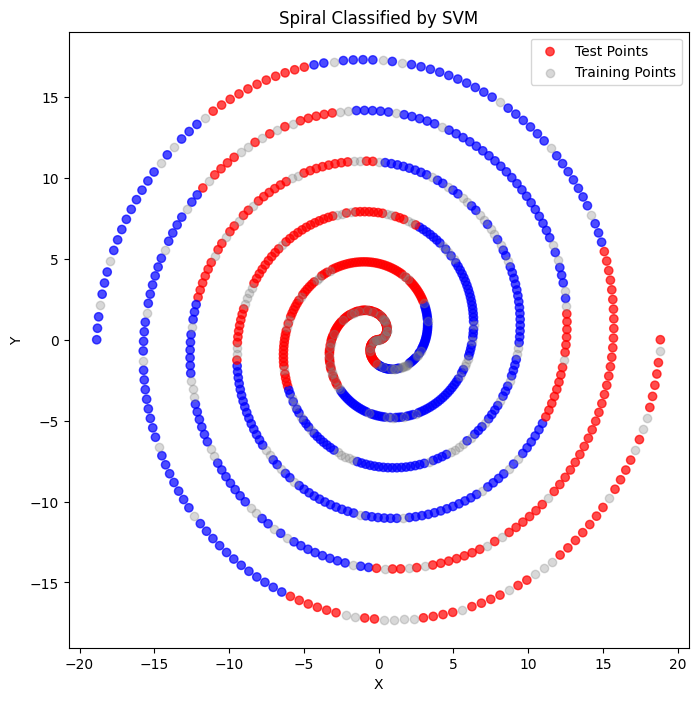

C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\3952951774.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


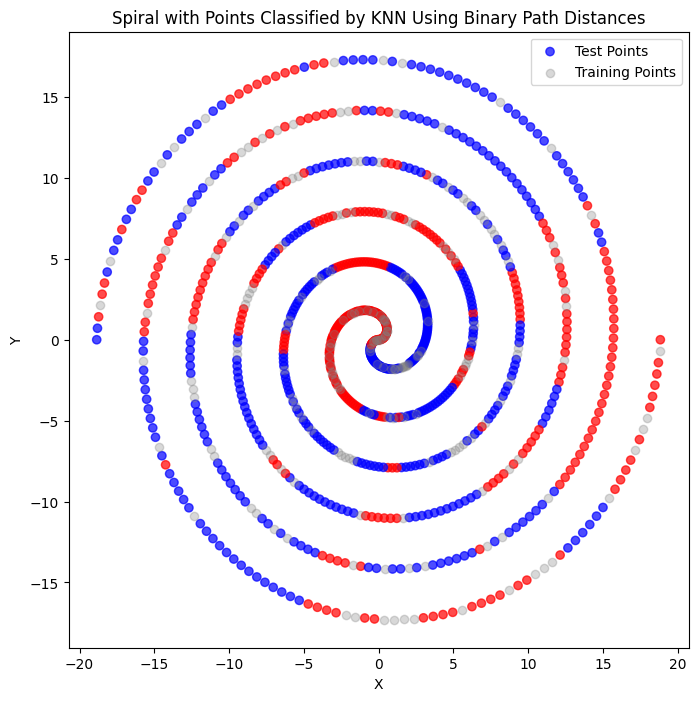

In [8]:
test_size = 0.8
num_neighbors = 5
train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)

D = pairwise_distances[:, train_idx]
train_distances = D[train_idx]
test_distances = D[test_idx]

train_labels = labels[train_idx]
test_labels = labels[test_idx]

knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
knn.fit(train_distances, train_labels)

print('KNN Score: ', knn.score(test_distances, test_labels))
predicted_labels = knn.predict(test_distances)
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Classification Accuracy: {accuracy:.2f}")

other_options(points, labels)

plt.figure(figsize=(8, 8))
colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
plt.scatter(points[train_idx, 0], points[train_idx, 1], c='gray', alpha=0.3, label="Training Points")
plt.title("Spiral with Points Classified by KNN Using Binary Path Distances")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

total train points: 200
KNN Score:  0.6425
Classification Accuracy: 0.64


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\3294489247.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


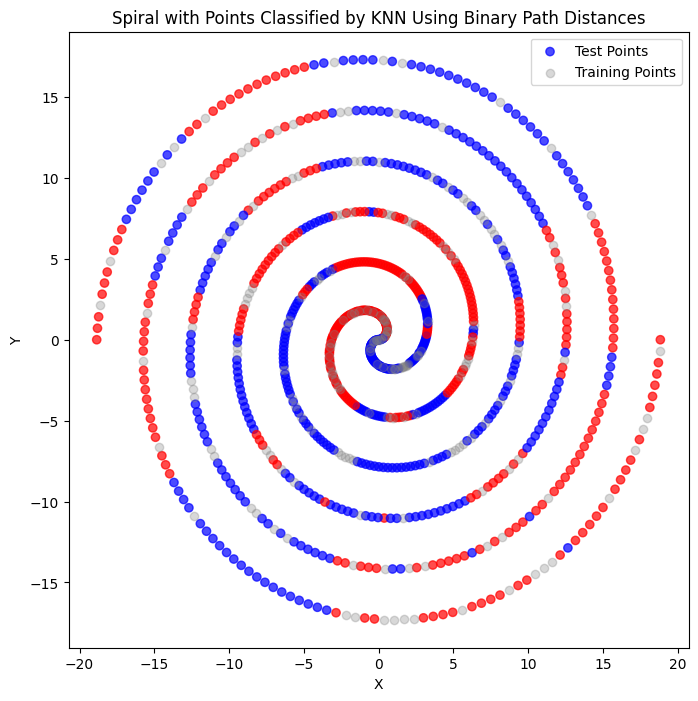

In [9]:
test_size = 0.8
num_neighbors = 5
train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)

train_points = points[train_idx]
print(f'total train points: {len(train_points)}')

random_trees = RandomTreesEmbedding(n_estimators=N_ESTIMATORS, random_state=42)
encoded_points = random_trees.fit_transform(train_points).toarray()

# Compute binary paths for all points
binary_paths = []
for estimator in random_trees.estimators_:
    leaf_indices = estimator.apply(points).ravel()
    for leaf_index in leaf_indices:
        binary_path = trace_binary_path(estimator.tree_, leaf_index)
        binary_paths.append(binary_path)
binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T

# Compute pairwise distances based on binary paths
num_points = len(points)
pairwise_distances = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(i + 1, num_points):
        avg_distance = 0
        for k in range(len(random_trees.estimators_)):
            avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
        avg_distance /= len(random_trees.estimators_)
        pairwise_distances[i, j] = avg_distance
        pairwise_distances[j, i] = avg_distance

D = pairwise_distances[:, train_idx]
train_distances = D[train_idx]
test_distances = D[test_idx]

train_labels = labels[train_idx]
test_labels = labels[test_idx]

knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
knn.fit(train_distances, train_labels)

print('KNN Score: ', knn.score(test_distances, test_labels))
predicted_labels = knn.predict(test_distances)
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Classification Accuracy: {accuracy:.2f}")

plt.figure(figsize=(8, 8))
colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
plt.scatter(points[train_idx, 0], points[train_idx, 1], c='gray', alpha=0.3, label="Training Points")
plt.title("Spiral with Points Classified by KNN Using Binary Path Distances")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

## Зашумленные данные

KNN Score:  0.61875
Classification Accuracy: 0.62
Extra Trees Accuracy: 0.7762


c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:01:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.7200
KNN Accuracy: 0.6937
SVM Accuracy: 0.4825
Extra Trees Accuracy: 0.7762


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


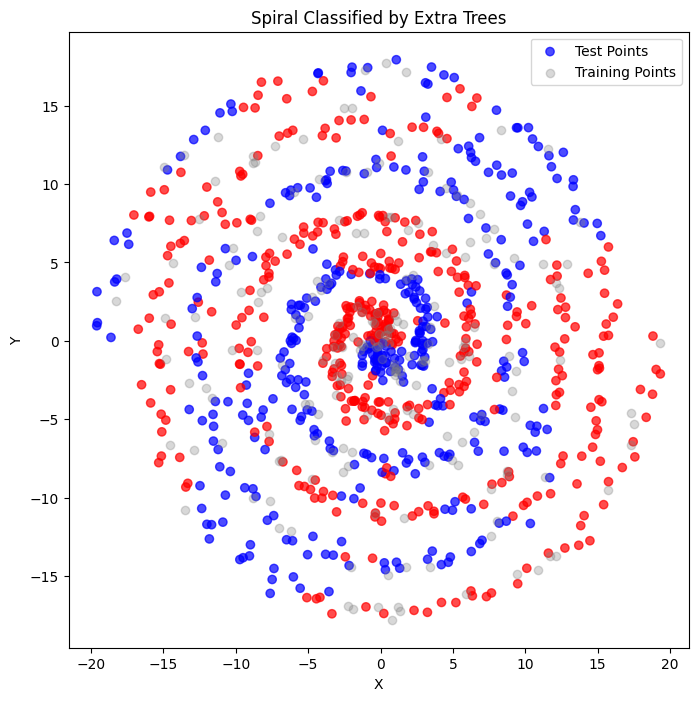

c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:01:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


XGBoost Accuracy: 0.7200


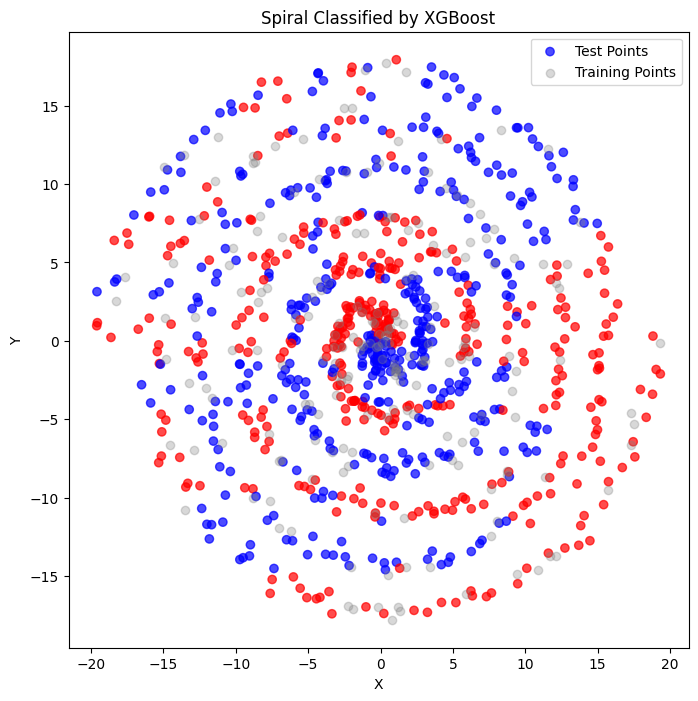

KNN Accuracy: 0.6937


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


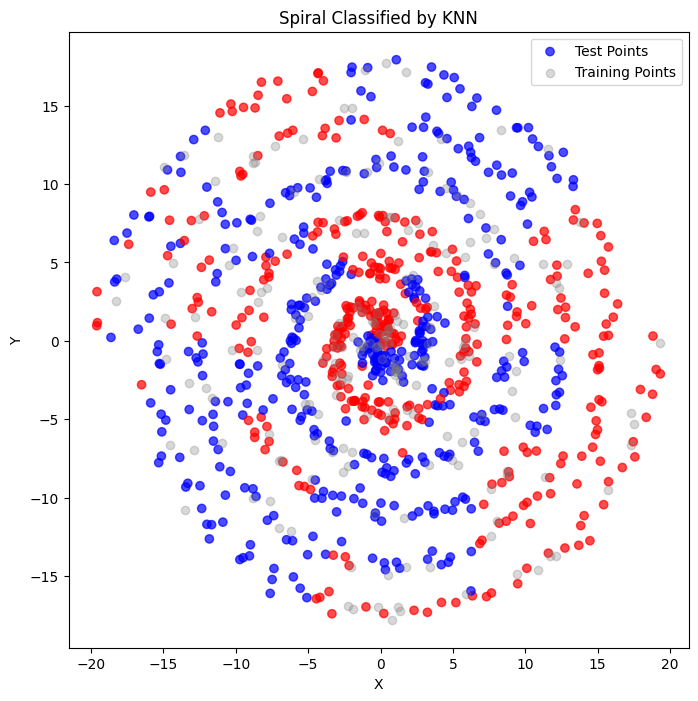

SVM Accuracy: 0.4825


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


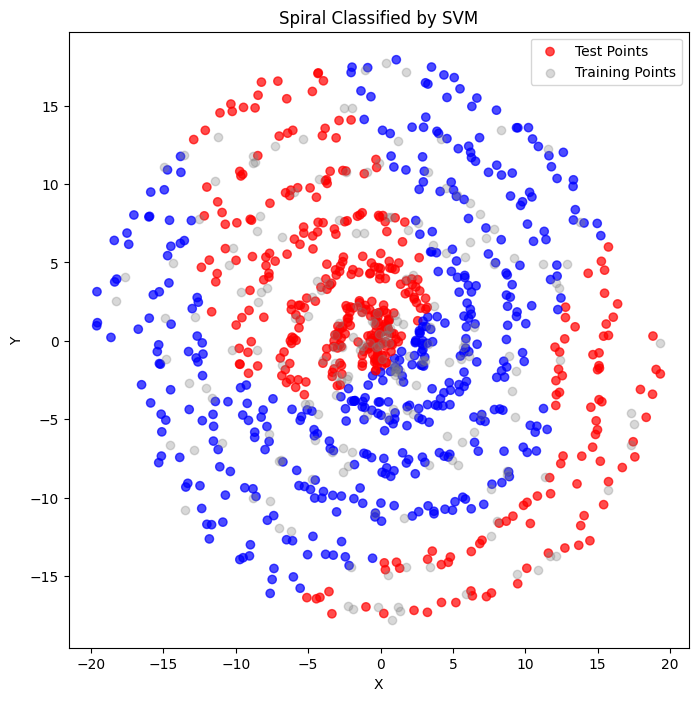

C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\394100523.py:73: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


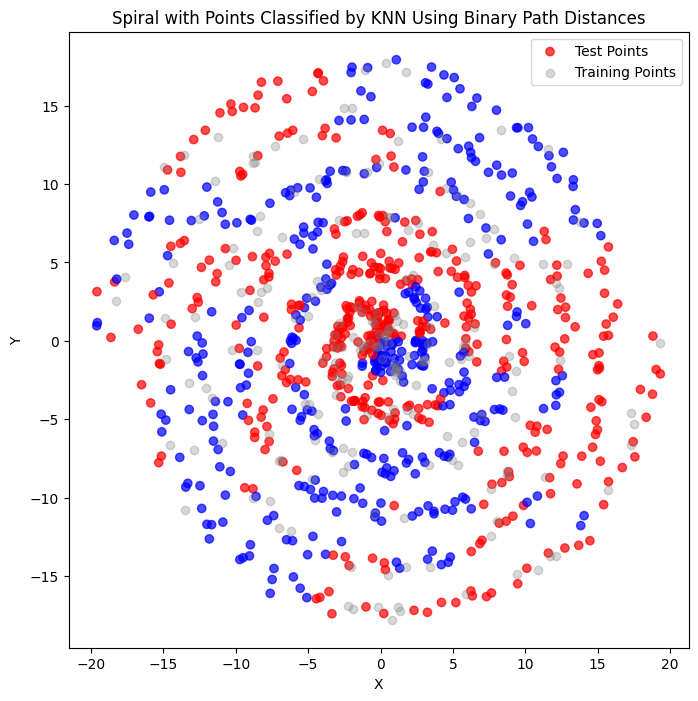

In [10]:
def generate_spirals(num_points=500):
    t = np.linspace(0, 6 * np.pi, num_points)
    std_dev = 0.5
    x_a = t * np.cos(t)
    y_a = t * np.sin(t)
    noise_x_a = np.random.normal(loc=0, scale=std_dev, size=x_a.shape)
    noise_y_a = np.random.normal(loc=0, scale=std_dev, size=y_a.shape)
    x_a = x_a + noise_x_a
    y_a = y_a + noise_y_a
    
    x_b = t * np.cos(t + np.pi)  
    y_b = t * np.sin(t + np.pi)
    noise_x_b = np.random.normal(loc=0, scale=std_dev, size=x_a.shape)
    noise_y_b = np.random.normal(loc=0, scale=std_dev, size=y_a.shape)
    x_b = x_b + noise_x_b
    y_b = y_b + noise_y_b
    points_a = np.vstack((x_a, y_a)).T
    points_b = np.vstack((x_b, y_b)).T
    labels_a = ['A'] * len(points_a)
    labels_b = ['B'] * len(points_b)
    return np.vstack((points_a, points_b)), np.hstack((labels_a, labels_b))



points, labels = generate_spirals()

N_ESTIMATORS = 10
random_trees = RandomTreesEmbedding(n_estimators=N_ESTIMATORS, random_state=42)
encoded_points = random_trees.fit_transform(points).toarray()

binary_paths = []
for estimator in random_trees.estimators_:
    leaf_indices = estimator.apply(points).ravel()
    for leaf_index in leaf_indices:
        binary_path = trace_binary_path(estimator.tree_, leaf_index)
        binary_paths.append(binary_path)
binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T

num_points = len(points)
pairwise_distances = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(i + 1, num_points):
        avg_distance = 0
        for k in range(len(random_trees.estimators_)):
            avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
        avg_distance /= len(random_trees.estimators_)
        pairwise_distances[i, j] = avg_distance
        pairwise_distances[j, i] = avg_distance

test_size = 0.8
num_neighbors = 5
train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)

D = pairwise_distances[:, train_idx]
train_distances = D[train_idx]
test_distances = D[test_idx]

train_labels = labels[train_idx]
test_labels = labels[test_idx]

knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
knn.fit(train_distances, train_labels)

print('KNN Score: ', knn.score(test_distances, test_labels))
predicted_labels = knn.predict(test_distances)
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Classification Accuracy: {accuracy:.2f}")

other_options(points, labels)

plt.figure(figsize=(8, 8))
colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
plt.scatter(points[train_idx, 0], points[train_idx, 1], c='gray', alpha=0.3, label="Training Points")
plt.title("Spiral with Points Classified by KNN Using Binary Path Distances")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

num neighbors: 5
total points: 1000
Total train points: 200
KNN Score:  0.6425
Classification Accuracy: 0.64


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\211786924.py:75: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


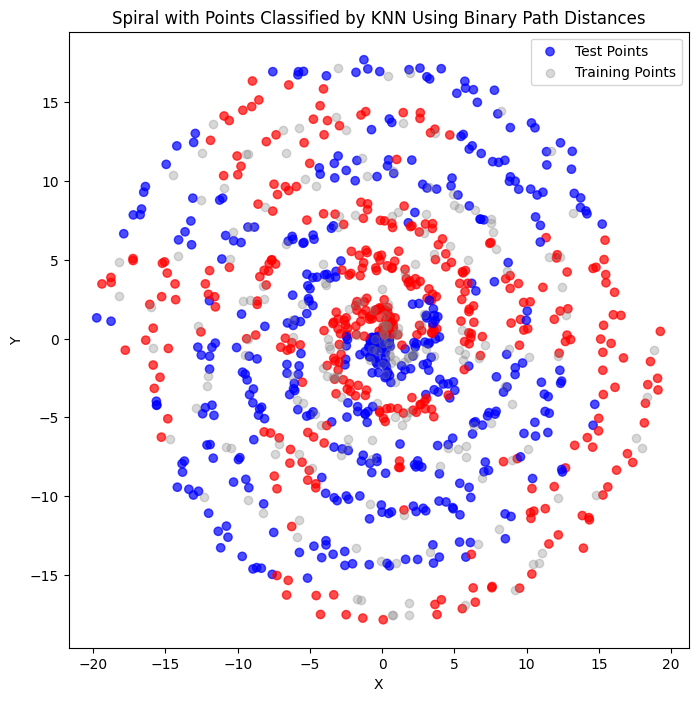

In [11]:
def generate_spirals(num_points=500):
    t = np.linspace(0, 6 * np.pi, num_points)
    std_dev = 0.5
    x_a = t * np.cos(t)
    y_a = t * np.sin(t)
    noise_x_a = np.random.normal(loc=0, scale=std_dev, size=x_a.shape)
    noise_y_a = np.random.normal(loc=0, scale=std_dev, size=y_a.shape)
    x_a = x_a + noise_x_a
    y_a = y_a + noise_y_a
    
    x_b = t * np.cos(t + np.pi)  
    y_b = t * np.sin(t + np.pi)
    noise_x_b = np.random.normal(loc=0, scale=std_dev, size=x_a.shape)
    noise_y_b = np.random.normal(loc=0, scale=std_dev, size=y_a.shape)
    x_b = x_b + noise_x_b
    y_b = y_b + noise_y_b
    points_a = np.vstack((x_a, y_a)).T
    points_b = np.vstack((x_b, y_b)).T
    labels_a = ['A'] * len(points_a)
    labels_b = ['B'] * len(points_b)
    return np.vstack((points_a, points_b)), np.hstack((labels_a, labels_b))


train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)

test_size = 0.8
num_neighbors = int(np.round(np.sqrt(len(train_idx))))
num_neighbors = 5
print(f'num neighbors: {num_neighbors}')

points, labels = generate_spirals()
print(f'total points: {len(points)}')
train_points = points[train_idx]
print(f'Total train points: {len(train_points)}')

random_trees = RandomTreesEmbedding(n_estimators=N_ESTIMATORS, random_state=42)
encoded_points = random_trees.fit_transform(train_points).toarray()

binary_paths = []
for estimator in random_trees.estimators_:
    leaf_indices = estimator.apply(points).ravel()
    for leaf_index in leaf_indices:
        binary_path = trace_binary_path(estimator.tree_, leaf_index)
        binary_paths.append(binary_path)
binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T

num_points = len(points)
pairwise_distances = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(i + 1, num_points):
        avg_distance = 0
        for k in range(len(random_trees.estimators_)):
            avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
        avg_distance /= len(random_trees.estimators_)
        pairwise_distances[i, j] = avg_distance
        pairwise_distances[j, i] = avg_distance

D = pairwise_distances[:, train_idx]
train_distances = D[train_idx]
test_distances = D[test_idx]

train_labels = labels[train_idx]
test_labels = labels[test_idx]

knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
knn.fit(train_distances, train_labels)

print('KNN Score: ', knn.score(test_distances, test_labels))
predicted_labels = knn.predict(test_distances)
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Classification Accuracy: {accuracy:.2f}")

plt.figure(figsize=(8, 8))
colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
plt.scatter(points[test_idx, 0], points[test_idx, 1], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
plt.scatter(points[train_idx, 0], points[train_idx, 1], c='gray', alpha=0.3, label="Training Points")
plt.title("Spiral with Points Classified by KNN Using Binary Path Distances")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

## Многомерные примеры

x shape: (500, 2)


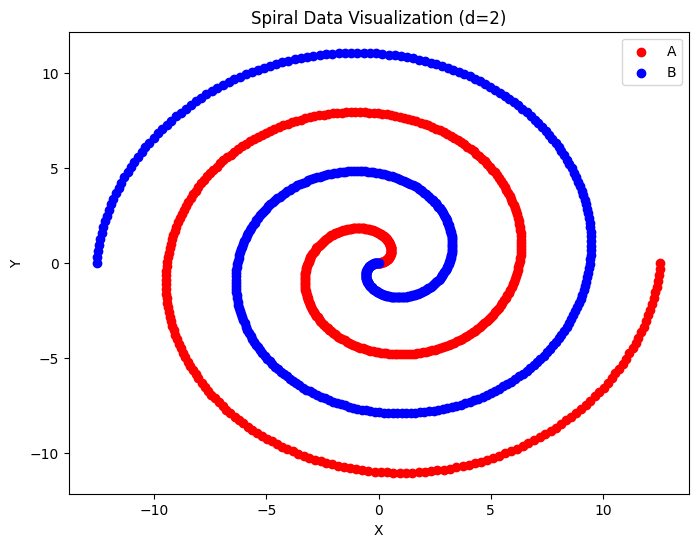

a shape: (2,)


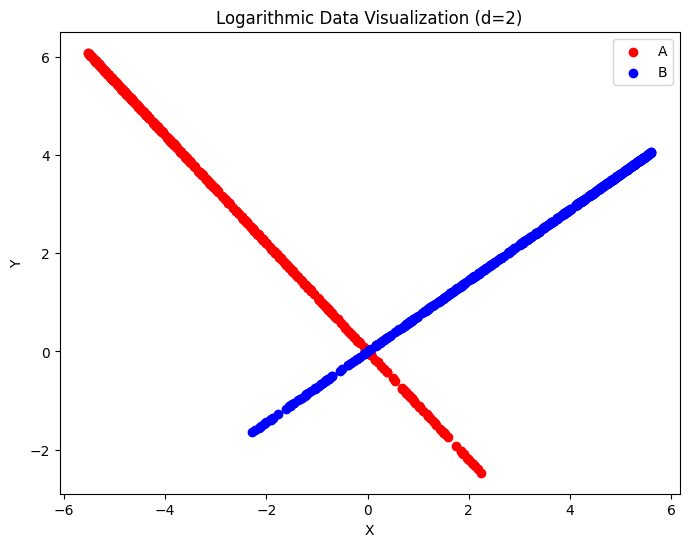

In [12]:
def dim_spirals(n, d, std_dev=0):
    t = np.linspace(0, 4 * np.pi, n)
    
    x = []
    for i in range(2, d + 1, 2):
        if std_dev != 0:
            cos_noise = np.random.normal(0, std_dev, n)
            sin_noise = np.random.normal(0, std_dev, n)
            x.append(t * np.cos(t * i / 2) + cos_noise)
            x.append(t * np.sin(t * i / 2) + sin_noise)
        else:
            x.append(t * np.cos(t * i / 2))
            x.append(t * np.sin(t * i / 2))
    x = np.array(x).T
    print(f'x shape: {x.shape}')
    labels_x = ['A'] * n
    
    y = []
    for i in range(2, d + 1, 2):
        if std_dev != 0:
            cos_noise = np.random.normal(0, std_dev, n)
            sin_noise = np.random.normal(0, std_dev, n)
            y.append(t * np.cos(t * i / 2 + np.pi) + cos_noise)
            y.append(t * np.sin(t * i / 2 + np.pi) + sin_noise)
        else:
            y.append(t * np.cos(t * i / 2 + np.pi))
            y.append(t * np.sin(t * i / 2 + np.pi))
    y = np.array(y).T
    labels_y = ['B'] * n
    
    points = np.vstack((x, y))
    labels = labels_x + labels_y
    
    if d == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(points[:n, 0], points[:n, 1], c='red', label='A')
        plt.scatter(points[n:, 0], points[n:, 1], c='blue', label='B')
        plt.title("Spiral Data Visualization (d=2)")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.show()
    
    return points, labels


def dim_logs_uniforms(d):
    a = []
    for _ in range(d):
        flip = np.random.randint(0, 2)
        if flip % 2 == 0:
            a.append(np.random.uniform(-4, -1))
        else:
            a.append(np.random.uniform(1, 4))
    a = np.array(a)
    return a


def dim_logs(n, d):
    t = np.random.uniform(0.5, 5, n)
    a = dim_logs_uniforms(d)
    print(f'a shape: {a.shape}')
    x = np.array([a_i * np.log(t) for a_i in a]).T
    labels_x = ['A'] * n
    
    b = dim_logs_uniforms(d)
    y = np.array([b_i * np.log(t) for b_i in b]).T
    labels_y = ['B'] * n
    
    points = np.vstack((x, y))
    labels = labels_x + labels_y
    
    if d == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(points[:n, 0], points[:n, 1], c='red', label='A')
        plt.scatter(points[n:, 0], points[n:, 1], c='blue', label='B')
        plt.title("Logarithmic Data Visualization (d=2)")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.show()
    
    return points, labels

N = 500
DIM = 2
points, labels = dim_spirals(N, DIM)
points, labels = dim_logs(N, DIM)

### Вспомогательные функции

In [13]:
def rte_distances(points, n_estimators=10):
    random_trees = RandomTreesEmbedding(n_estimators=n_estimators, random_state=42)
    encoded_points = random_trees.fit_transform(points).toarray()

    binary_paths = []
    for estimator in random_trees.estimators_:
        leaf_indices = estimator.apply(points).ravel()
        for leaf_index in leaf_indices:
            binary_path = trace_binary_path(estimator.tree_, leaf_index)
            binary_paths.append(binary_path)

    binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T
    print(f'paths shape: {binary_paths.shape}')

    num_points = len(points)
    pairwise_distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i + 1, num_points):
            avg_distance = 0
            for k in range(len(random_trees.estimators_)):
                # print(i, j, k)
                try:
                    avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
                except IndexError as ie:
                    print(ie, binary_paths[i][k], binary_paths[j][k])
                    children(random_trees.estimators_[k].tree_)
                    print(
                        random_trees.estimators_[k].apply([points[i], points[j]]),
                    )
                    raise IndexError(ie)
            avg_distance /= len(random_trees.estimators_)
            pairwise_distances[i, j] = avg_distance
            pairwise_distances[j, i] = avg_distance
    return pairwise_distances


def test_rte(points, labels, pairwise_distances, test_size=0.8, num_neighbors=5):
    # num_neighbors = 5
    num_points = len(points)
    print(f'num points: {num_points}')
    train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)
    # print(f'train idx: {train_idx}')
    D = pairwise_distances[:, train_idx]
    train_distances = D[train_idx] 
    test_distances = D[test_idx] 
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]

    knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
    knn.fit(train_distances, train_labels)

    print('KNN Score: ', knn.score(test_distances, test_labels))

    predicted_labels = knn.predict(test_distances)

    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"Classification Accuracy: {accuracy:.2f}")


def rte_distances_for_train(points, train_idx, n_estimators=10):
    train_points = points[train_idx]
    random_trees = RandomTreesEmbedding(n_estimators=n_estimators, random_state=42)
    encoded_points = random_trees.fit_transform(train_points).toarray()

    binary_paths = []
    for estimator in random_trees.estimators_:
        leaf_indices = estimator.apply(points).ravel()
        for leaf_index in leaf_indices:
            binary_path = trace_binary_path(estimator.tree_, leaf_index)
            binary_paths.append(binary_path)

    binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T
    print(f'paths shape: {binary_paths.shape}')

    num_points = len(points)
    pairwise_distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i + 1, num_points):
            avg_distance = 0
            for k in range(len(random_trees.estimators_)):
                # print(i, j, k)
                try:
                    avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
                except IndexError as ie:
                    print(ie, binary_paths[i][k], binary_paths[j][k])
                    children(random_trees.estimators_[k].tree_)
                    print(
                        random_trees.estimators_[k].apply([points[i], points[j]]),
                    )
                    raise IndexError(ie)
            avg_distance /= len(random_trees.estimators_)
            pairwise_distances[i, j] = avg_distance
            pairwise_distances[j, i] = avg_distance
    return pairwise_distances


def test_rte_train(points, labels, test_size=0.8, n_estimators=10, num_neighbors=5):
    # num_neighbors = 5
    num_points = len(points)

    train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)
    pairwise_distances = rte_distances_for_train(points, train_idx, n_estimators)
    D = pairwise_distances[:, train_idx]
    train_distances = D[train_idx] 
    test_distances = D[test_idx] 
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]

    knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
    knn.fit(train_distances, train_labels)

    print('KNN Score: ', knn.score(test_distances, test_labels))

    predicted_labels = knn.predict(test_distances)

    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"Classification Accuracy: {accuracy:.2f}")


#### Спирали

In [14]:
N = 500
DIM = 8
N_ESTIMATORS = 10
points, labels = dim_spirals(N, DIM)
labels = np.array(labels)
pairwise_distances = rte_distances(points, N_ESTIMATORS)

x shape: (500, 8)
paths shape: (1000, 10)


In [15]:
print(points.shape)
print(labels.shape)
print(pairwise_distances.shape)

(1000, 8)
(1000,)
(1000, 1000)


num points: 1000
KNN Score:  0.81125
Classification Accuracy: 0.81
Extra Trees Accuracy: 0.9563
XGBoost Accuracy: 0.9350


c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


KNN Accuracy: 0.9725
SVM Accuracy: 0.8237
Extra Trees Accuracy: 0.9563


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


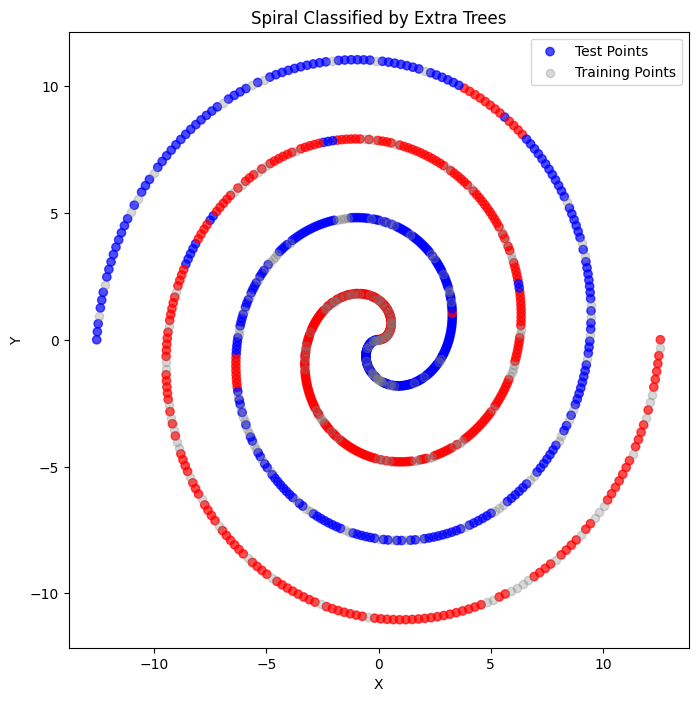

c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


XGBoost Accuracy: 0.9350


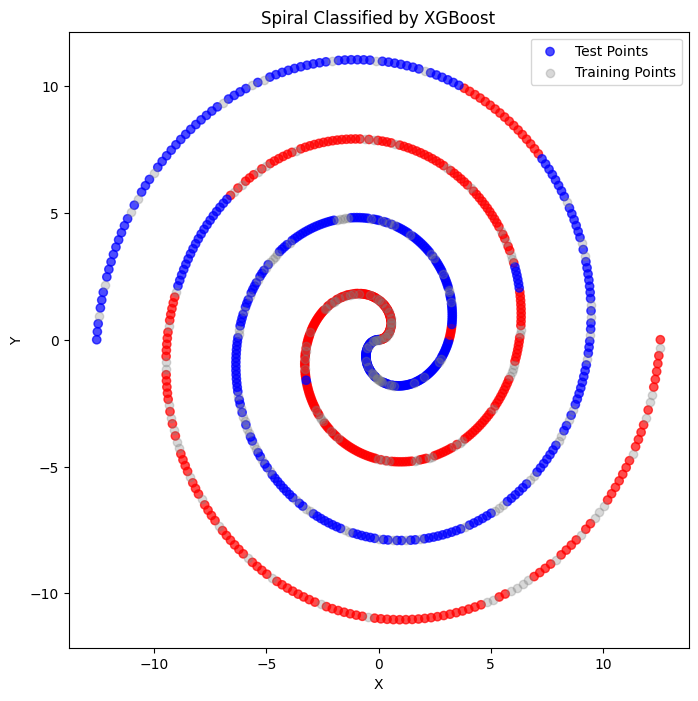

KNN Accuracy: 0.9725


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


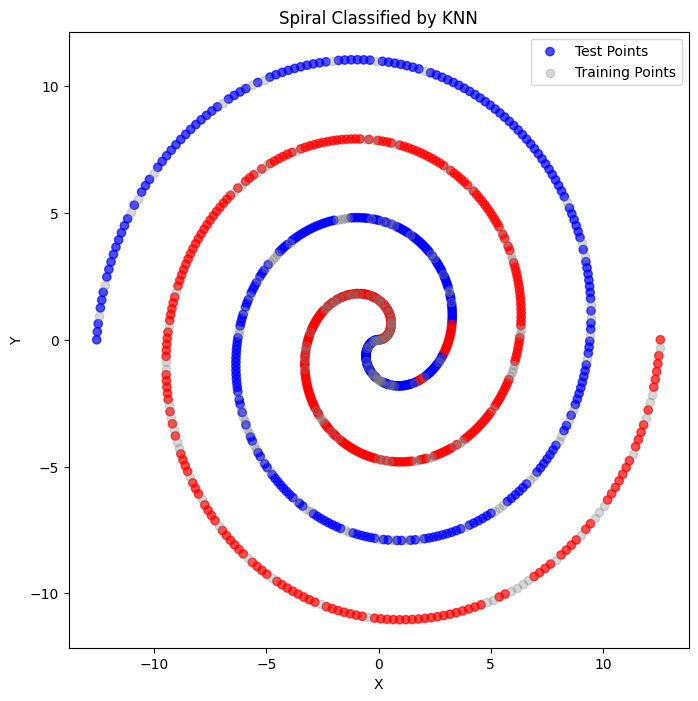

SVM Accuracy: 0.8237


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


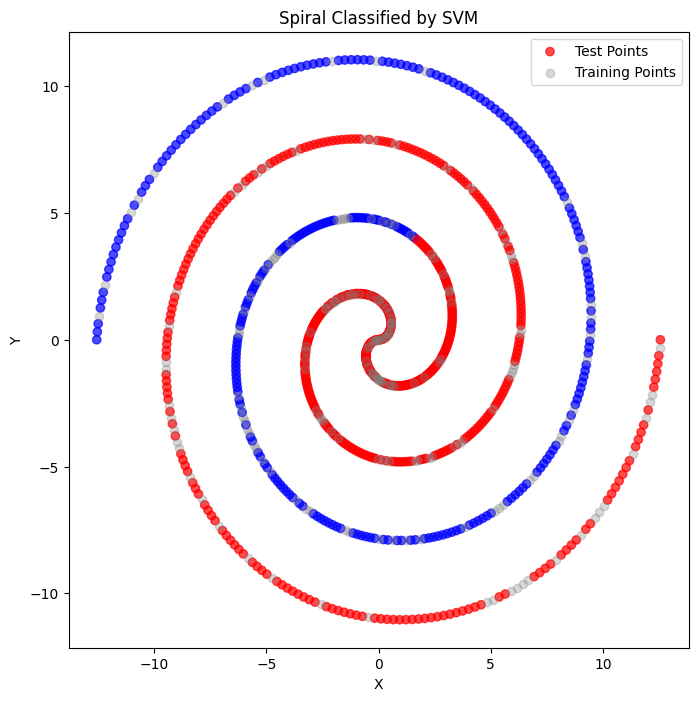

In [16]:
test_rte(points, labels, pairwise_distances)
other_options(points, labels)

#### Логарифмы

In [17]:
N = 500
DIM = 8
N_ESTIMATORS = 10
points, labels = dim_logs(N, DIM)
labels = np.array(labels)
# print(points.shape)
# print(labels.shape)
pairwise_distances = rte_distances(points, N_ESTIMATORS)

a shape: (8,)
paths shape: (1000, 10)


num points: 1000
KNN Score:  0.9575
Classification Accuracy: 0.96
Extra Trees Accuracy: 0.9775
XGBoost Accuracy: 0.9900
KNN Accuracy: 0.9838
SVM Accuracy: 0.9163


c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Extra Trees Accuracy: 0.9775


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


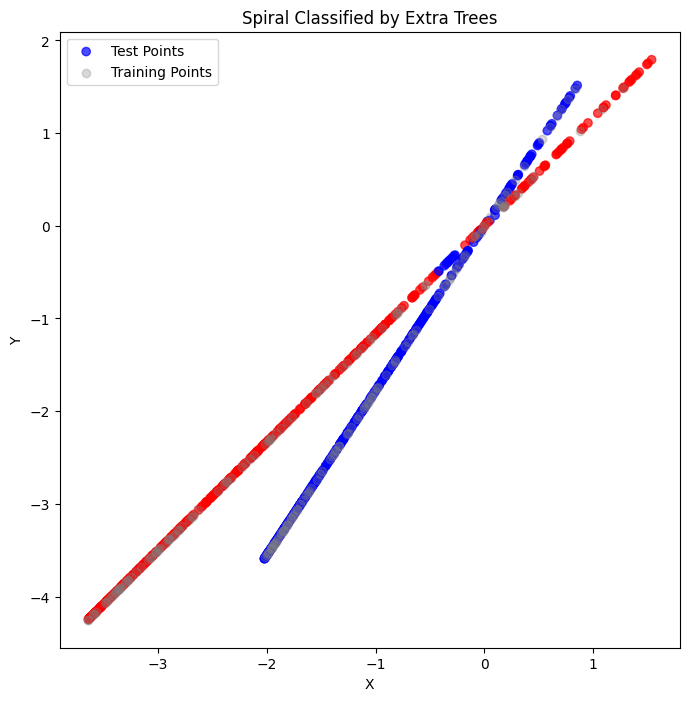

c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


XGBoost Accuracy: 0.9900


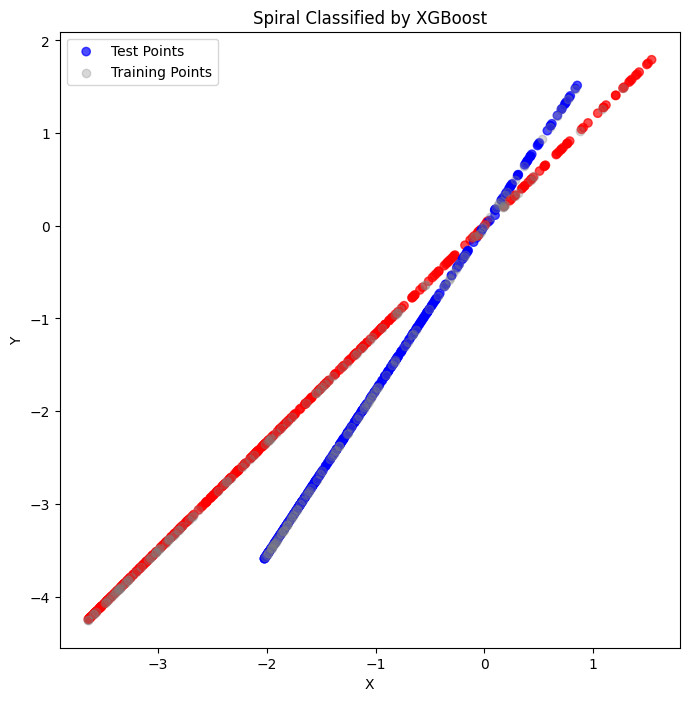

KNN Accuracy: 0.9838


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


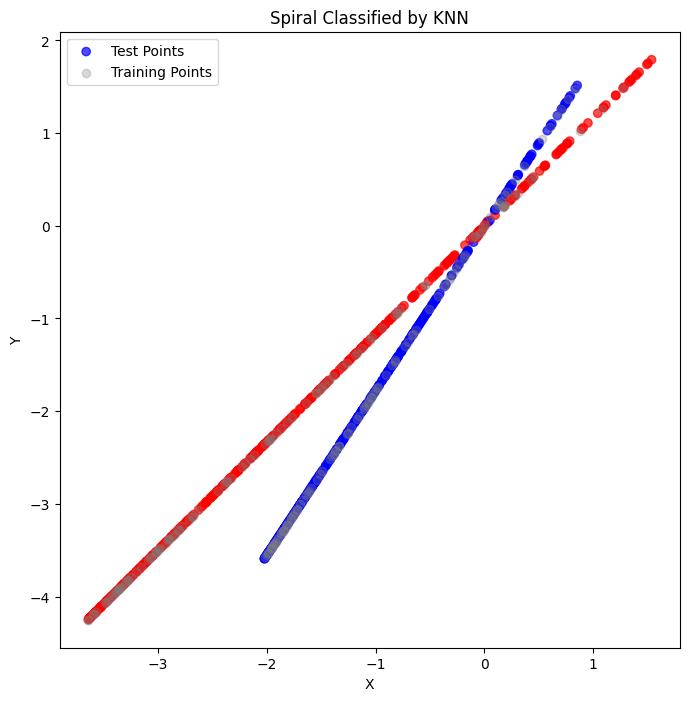

SVM Accuracy: 0.9163


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


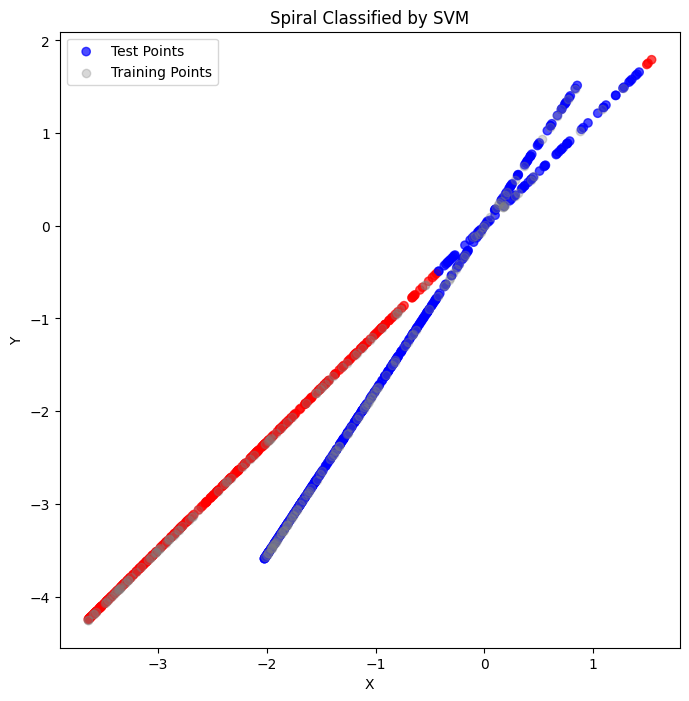

In [18]:
test_rte(points, labels, pairwise_distances)
other_options(points, labels)

### Многомерные данные с шумом

In [19]:
N = 500
DIM = 8
N_ESTIMATORS = 10
points, labels = dim_spirals(N, DIM, 0.5)
labels = np.array(labels)
pairwise_distances = rte_distances(points, N_ESTIMATORS)

x shape: (500, 8)
paths shape: (1000, 10)


num points: 1000
KNN Score:  0.81
Classification Accuracy: 0.81
Extra Trees Accuracy: 0.8938
XGBoost Accuracy: 0.9237


c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


KNN Accuracy: 0.9450
SVM Accuracy: 0.8225
Extra Trees Accuracy: 0.8938


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


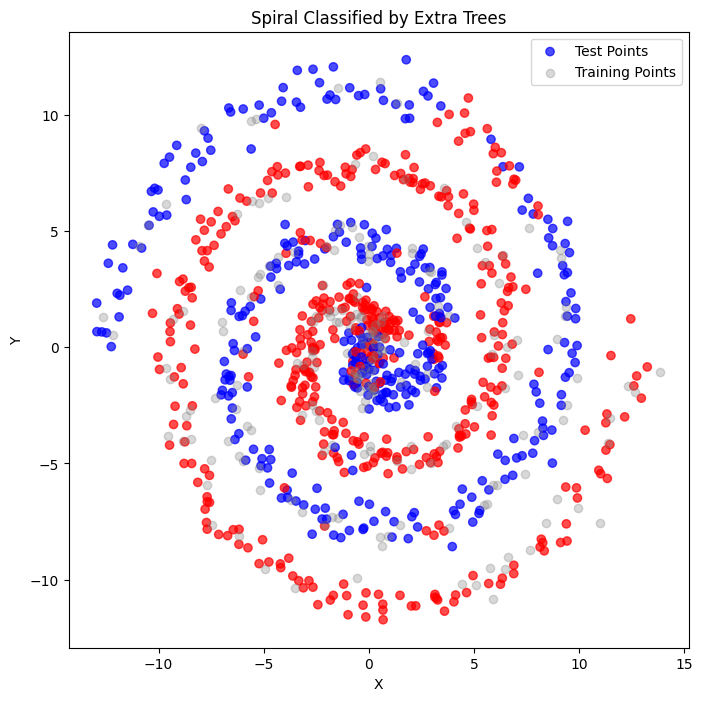

c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


XGBoost Accuracy: 0.9237


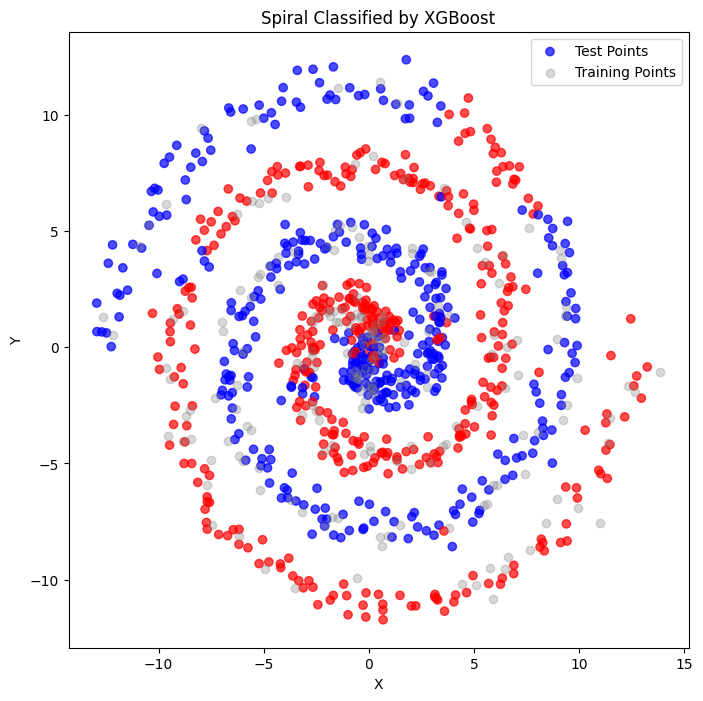

KNN Accuracy: 0.9450


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


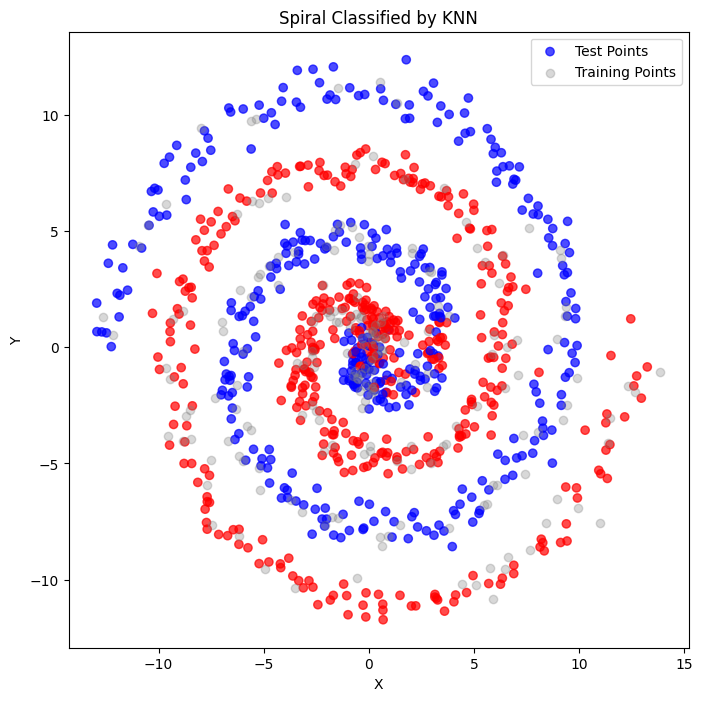

SVM Accuracy: 0.8225


C:\Users\Максим\AppData\Local\Temp\ipykernel_46292\1574636196.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y_test, c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


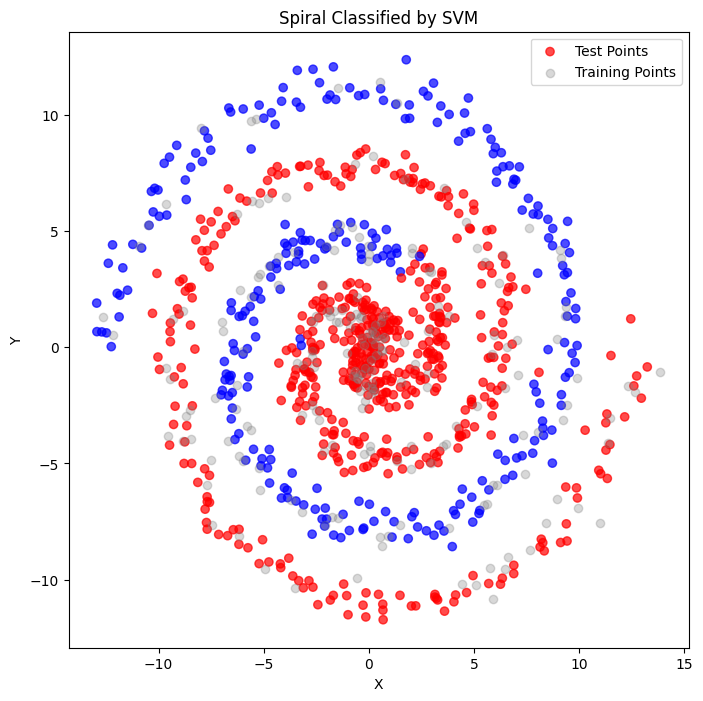

In [20]:
test_rte(points, labels, pairwise_distances)
other_options(points, labels)

### ExtraTreesClassifier как база

#### Проверка формулы через ExtraTrees 

In [21]:
from sklearn.ensemble import ExtraTreesClassifier


def plane_points(n: int, std_dev = 0):
    t = np.linspace(0, 6 * np.pi, n)
    x_a = t * np.cos(t)
    y_a = t * np.sin(t)
    x_b = t * np.cos(t + np.pi)
    y_b = t * np.sin(t + np.pi)
    if std_dev != 0:
        x_a = x_a + np.random.normal(0, std_dev, n)
        y_a = y_a + np.random.normal(0, std_dev, n)
        x_b = x_b + np.random.normal(0, std_dev, n)
        y_b = y_b + np.random.normal(0, std_dev, n)
    points_a = np.vstack((x_a, y_a)).T
    points_b = np.vstack((x_b, y_b)).T
    labels_a = ['A'] * len(points_a)
    labels_b = ['B'] * len(points_b)
    return np.vstack((points_a, points_b)), np.hstack((labels_a, labels_b))


def distances_ET(points, labels, train_idx, n_estimators=10):
    train_points = points[train_idx]
    train_labels = labels[train_idx]
    extrees = ExtraTreesClassifier(n_estimators=n_estimators, random_state=42)
    extrees.fit(train_points, train_labels)

    binary_paths = []
    for estimator in extrees.estimators_:
        leaf_indices = estimator.apply(points).ravel()
        for leaf_index in leaf_indices:
            binary_path = trace_binary_path(estimator.tree_, leaf_index)
            binary_paths.append(binary_path)

    binary_paths = np.array(binary_paths).reshape(len(extrees.estimators_), len(points)).T
    print(f'paths shape: {binary_paths.shape}')

    num_points = len(points)
    pairwise_distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i + 1, num_points):
            avg_distance = 0
            for k in range(len(extrees.estimators_)):
                # print(i, j, k)
                try:
                    avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
                except IndexError as ie:
                    print(ie, binary_paths[i][k], binary_paths[j][k])
                    children(extrees.estimators_[k].tree_)
                    print(
                        extrees.estimators_[k].apply([points[i], points[j]]),
                    )
                    raise IndexError(ie)
            avg_distance /= len(extrees.estimators_)
            pairwise_distances[i, j] = avg_distance
            pairwise_distances[j, i] = avg_distance
    return pairwise_distances


def compared_methods(points, labels, test_size = 0.8, et_estimators: int = 10, visualize = True):
    X = points
    label_encoder = LabelEncoder()
    trans_labels = label_encoder.fit_transform(labels)
    train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)
    # print(train_idx, test_idx)
    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = trans_labels[train_idx]
    y_test = trans_labels[test_idx]
    # X_train, X_test, y_train, y_test = train_test_split(X, trans_labels, test_size=test_size, random_state=42)

    classifiers = {
        "Extra Trees": ExtraTreesClassifier(n_estimators=et_estimators, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=num_neighbors),
        "SVM": SVC(kernel='rbf', random_state=42)
    }

    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy: {accuracy:.4f}")
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        predicted_labels = label_encoder.inverse_transform(y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy: {accuracy:.4f}")
        if visualize:
            visualize_results(X_train, X_test, y_train, y_test, predicted_labels, title=f"Spiral Classified by {name}")


def test_ET(points, labels, test_size=0.8, n_estimators=10, num_neighbors=5):
    num_points = len(points)

    train_idx, test_idx = train_test_split(np.arange(num_points), test_size=test_size, random_state=42)
    # print(train_idx, test_idx)
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    pairwise_distances = distances_ET(points, labels, train_idx, n_estimators)
    D = pairwise_distances[:, train_idx]
    train_distances = D[train_idx] 
    test_distances = D[test_idx]

    knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
    knn.fit(train_distances, train_labels)

    predicted_labels = knn.predict(test_distances)

    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"Classification Accuracy: {accuracy:.4f}")

In [22]:
def test_dist_ET():
    n = 20
    n_estimators = 10
    points, labels = plane_points(n)
    a_point = np.random.randint(0, len(points))
    b_point = np.random.randint(0, len(points))
    extrees = ExtraTreesClassifier(n_estimators=n_estimators, random_state=42)
    extrees.fit(points, labels)
    k = np.random.randint(0, n_estimators)
    # a_point, b_point, k = 146, 883, 1
    
    
    print(f'first point: {a_point}, second point: {b_point}, tree: {k}')
    print('Tree structure:')
    actual_estimator = extrees.estimators_[k]
    print_tree(actual_estimator.tree_)
    leaf_a, leaf_b = actual_estimator.apply([points[a_point], points[b_point]])
    print('Leaves:')
    print(leaf_a, leaf_b)
    path_a, path_b = trace_binary_path(actual_estimator.tree_, leaf_a), trace_binary_path(actual_estimator.tree_, leaf_b)
    print(f'Binary paths:\n first: {path_a}, second: {path_b}')


test_dist_ET()

first point: 26, second point: 1, tree: 1
Tree structure:
  1:1
0:0
              7:8
            6:7
              7:9
          5:6
                8:12
              7:11
                8:13
            6:10
              7:14
        4:5
                8:18
              7:17
                8:19
            6:16
              7:20
          5:15
                  9:24
                8:23
                        12:28
                      11:27
                          13:30
                        12:29
                          13:31
                    10:26
                        12:33
                      11:32
                        12:34
                  9:25
                      11:36
                    10:35
                      11:37
              7:22
                8:38
            6:21
              7:39
      3:4
          5:41
        4:40
              7:44
            6:43
              7:45
          5:42
              7:47
            6:46
          

In [23]:
N = 500
N_ESTIMATORS = 100
points, labels = plane_points(N)
print(points.shape)
print(labels.shape)

(1000, 2)
(1000,)


In [24]:
test_ET(points, labels, n_estimators=N_ESTIMATORS)
compared_methods(points, labels, et_estimators=N_ESTIMATORS, visualize=False)

paths shape: (1000, 100)


KeyboardInterrupt: 

In [40]:
N = 500
DIM = 8
N_ESTIMATORS = 25
test_size = 0.8
points, labels = dim_spirals(N, DIM, std_dev=0.5)
labels = np.array(labels)
print(points.shape)
print(labels.shape)

train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)

test_ET(points, labels, n_estimators=N_ESTIMATORS, num_neighbors=3)
compared_methods(points, labels, et_estimators=N_ESTIMATORS, visualize=False)

x shape: (500, 8)
(1000, 8)
(1000,)
paths shape: (1000, 25)
Classification Accuracy: 0.9363
Extra Trees Accuracy: 0.9413


c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [12:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9187
KNN Accuracy: 0.9575
SVM Accuracy: 0.8125
Extra Trees Accuracy: 0.9413


c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [12:31:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9187
KNN Accuracy: 0.9575
SVM Accuracy: 0.8125


### Сравнение ExtraTree(1) с dist_ET(KNN=1, ET=1)

paths shape: (1000, 1)
Classification Accuracy: 0.7063
Single ExtraTree accuracy: 0.7063
(800, 2) (800,)


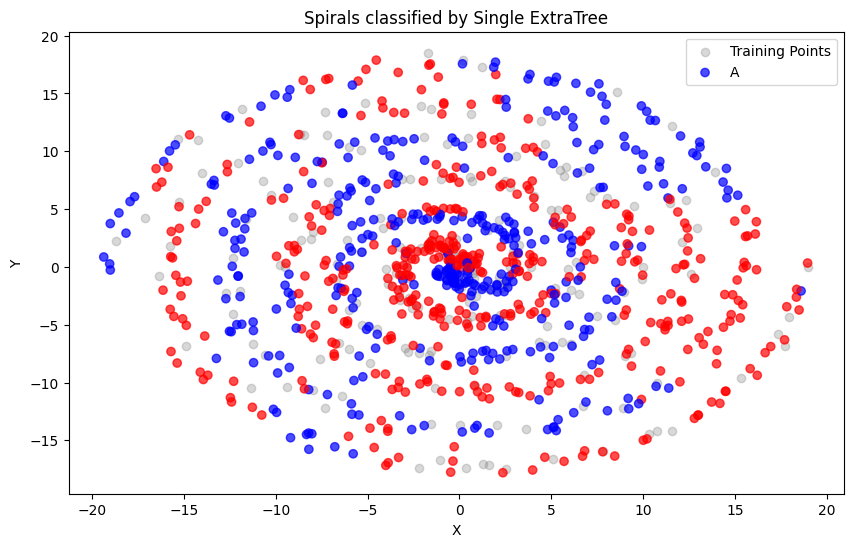

In [34]:
N = 500
test_size = 0.8
points, labels = generate_spirals(N)

def single_et(points, labels, test_size = 0.8, visualize=True):
    X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=test_size, random_state=42)

    extree = ExtraTreesClassifier(n_estimators=1, random_state=42)
    extree.fit(X_train, y_train)
    y_pred = extree.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Single ExtraTree accuracy: {accuracy:.4f}")
    
    predicted_labels = extree.predict(X_test)
    colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train[:, 0], X_train[:, 1], c='gray', label='Training Points', alpha=0.3)
    print(X_test.shape, y_test.shape)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=colors, label='A', alpha=0.7)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Spirals classified by Single ExtraTree')
    plt.legend()
    plt.show()


test_ET(points, labels, test_size=test_size, n_estimators=1, num_neighbors=1)
single_et(points, labels, test_size=test_size)

#### ExtraTree to Binary path

In [52]:
def et_binary_path(tree, truei, curi, acc):
    left = tree.children_left
    right = tree.children_right
    if left[curi] == -1 and right[curi] == -1:
        if curi == truei:
            acc.append(1)
        else:
            acc.append(0)
        return acc
    acc = et_binary_path(tree, truei, left[curi], acc)
    return et_binary_path(tree, truei, right[curi], acc)

points, labels = generate_spirals(20)
rp = np.random.randint(0, len(points))
X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.8, random_state=42)
extree = ExtraTreesClassifier(n_estimators=1)
extree.fit(X_train, y_train)
print_tree(extree.estimators_[0].tree_)
print(type(points[rp]))
leaf = extree.apply([points[rp]])[0][0]
print(f'Leaf index for {rp}: {leaf}')
path = et_binary_path(extree.estimators_[0].tree_, leaf, 0, [])
print(path)

      3:3
    2:2
        4:5
      3:4
        4:6
  1:1
    2:7
0:0
    2:9
  1:8
    2:10
<class 'numpy.ndarray'>
Leaf index for 27: 5
[0, 1, 0, 0, 0, 0]


In [75]:
def ET_embedding(extrees: ExtraTreesClassifier, points):
    # print(extrees.apply(points))
    binary_paths = []
    for point in points:
        paths = []
        for est in extrees.estimators_:
            # print(est.apply([point]))
            paths.append(et_binary_path(est.tree_, est.apply([point])[0], 0, []))
        binary_paths.append(np.array([x for sl in paths for x in sl]))
    return binary_paths


def eucl_dist_for_binary_paths(left: np.ndarray, right: np.ndarray):
    return np.sqrt(np.sum(np.not_equal(left, right)))


points, labels = generate_spirals(20)
X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.8, random_state=42)
extrees = ExtraTreesClassifier(n_estimators=5)
extrees.fit(X_train, y_train)


def pairwise_distances_for_ET_paths(points, extrees: ExtraTreesClassifier):
    num_points = len(points)
    distances = np.zeros((num_points, num_points))
    binary_paths = np.array(ET_embedding(extrees, points))
    print(binary_paths.shape)
    print(len(binary_paths))
    for i in range(num_points):
        for j in range(i + 1, num_points):
            # print(i, j)
            # print(len(binary_paths[i]), len(binary_paths[j]))
            eucl_dist_for_binary_paths(binary_paths[i], binary_paths[j])
            distances[i][j] = distances[j][i] = eucl_dist_for_binary_paths(binary_paths[i], binary_paths[j])
    return distances


def test_KNN_by_ET_embedding_dist(points, labels, et_estimators = 5, num_neighbors = 5):
    train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=0.8, random_state=42)
    X_train = points[train_idx]
    X_test = points[test_idx]
    y_train = labels[train_idx]
    y_test = labels[test_idx]
    extrees = ExtraTreesClassifier(n_estimators=et_estimators, random_state=42)
    extrees.fit(X_train, y_train)
    pairwise_distances = pairwise_distances_for_ET_paths(points, extrees)
    D = pairwise_distances[:, train_idx]
    train_distances = D[train_idx] 
    test_distances = D[test_idx]

    knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
    knn.fit(train_distances, train_labels)
    predicted_labels = knn.predict(test_distances)

    accuracy = accuracy_score(y_test, predicted_labels)
    print(f"ET embedding dist accuracy: {accuracy:.4f}")


def pure_ET_test(points, labels, et_estimators = 5):
    X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.8, random_state=42)
    extrees = ExtraTreesClassifier(n_estimators=et_estimators, random_state=42)
    extrees.fit(X_train, y_train)
    predicted_labels = extrees.predict(X_test)
    accuracy = accuracy_score(y_test, predicted_labels)
    print(f"Pure ExtraTrees accuracy: {accuracy:.4f}")


# print(eucl_dist_for_binary_paths([0, 0, 1, 0, 0, 1, 0], [1, 0, 0, 0, 0, 1, 0]))
# print(ET_embedding(extrees, points))

N = 500
N_estimators = 5
points, labels = generate_spirals(N)
test_KNN_by_ET_embedding_dist(points, labels, et_estimators=N_estimators)
test_ET(points, labels, n_estimators=N_estimators)
pure_ET_test(points, labels, et_estimators=N_estimators)


(1000, 596)
1000
ET embedding dist accuracy: 0.7175
paths shape: (1000, 5)
Classification Accuracy: 0.7037
Pure ExtraTrees accuracy: 0.7375
